## Importing the required libraries

In [1]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# import string
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils import resample
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tag import pos_tag #library used for POS tagging
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Max\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Max\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Understanding and Exploration

This section, dataset is explore to get an understanding of where to proceed and what to take care of first

In [2]:
#Parse JSON file
sm_tweets = pd.read_json('CETM47-22_23-AS2-Data.json')
pd.set_option('display.max_colwidth', None)
sm_tweets.head(5)

,text,date,label,id,label_name
0,"The {@Clinton LumberKings@} beat the {@Cedar Rapids Kernels@} 4-0 in Game 1 of the Western Division finals. Evan Edwards hit a 2-run HR. WP Josh Roberson: 5 IP, 3 H, 0 R, 0 BB, 10 K #MWLplayoffs #MWLscoreboard",2019-09-08,4,1170516324419866624,sports_&_gaming
1,I would rather hear Eli Gold announce this Auburn game than these dumbasses. {@ESPN@},2019-09-08,4,1170516440690176006,sports_&_gaming
2,"Someone take my phone away, I’m trying to not look at {@Chicago Blackhawks@} home game tickets in October",2019-09-08,4,1170516543387709440,sports_&_gaming
3,"A year ago, Louisville struggled to beat an FCS opponent, ISU. Yes they won 31-7, but score wasn’t indicative of the game flow. Today, they are demoralizing a better FCS opponent in EKU. {@Coach Satterfield@} thank you!! {{USERNAME}} , glad you’re gone.",2019-09-08,4,1170516620466429953,sports_&_gaming
4,Anyone know why the #Dodgers #Orioles game next Thursday 9/12 is on Fox?? That’s arguably the last game on the entire schedule I’d imagine being on Fox. {@Bill Shaikin@} {@Eric Stephen@} {@David Vassegh@},2019-09-08,4,1170516711411310592,sports_&_gaming


In [3]:
sm_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6443 entries, 0 to 6442
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   text        6443 non-null   object        
 1   date        6443 non-null   datetime64[ns]
 2   label       6443 non-null   int64         
 3   id          6443 non-null   int64         
 4   label_name  6443 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 251.8+ KB


In [4]:
#Check for missing values
null_value = sm_tweets.isnull().sum().sum()
print(f'There are {null_value} missing values.')

There are 0 missing values.


In [5]:
# Count the rows based on the label_id column
row_counts = sm_tweets['label_name'].value_counts()
# Print the count of each label_id
print(row_counts)

pop_culture                 2512
sports_&_gaming             2291
daily_life                   883
science_&_technology         326
business_&_entrepreneurs     287
arts_&_culture               144
Name: label_name, dtype: int64


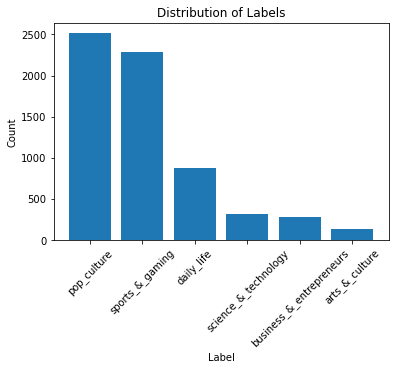

In [6]:
# Count the rows based on the label_id column
row_counts = sm_tweets['label_name'].value_counts()

# Create a bar chart
plt.bar(row_counts.index, row_counts.values)

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Display the chart
plt.show()

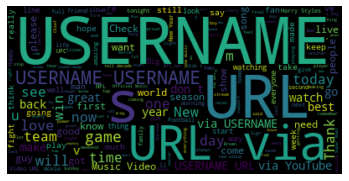

In [7]:
# Extract the text column

text_data = sm_tweets['text'].astype(str)

# Concatenate all the text data into a single string
text = ' '.join(text_data)

# Generate word cloud
wordcloud = WordCloud().generate(text)

# Create a plot and display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## Data Cleaning and Normalization

In [8]:
# regex_removal = r'{@|@}|{{USERNAME}}|{{URL}}|#\w+|[\.!&’?/♂️,-]'
# regex_removal = r'{@|@}|{{USERNAME}}|{{URL}}|#\w+|[\.!&’?/♂️,-]|\d+'
# regex_removal = r'{@|@}|{{USERNAME}}|{{URL}}|#\w+|[\.!&’?/♂️:,-]|\b\w{1,2}\b|\d+'
# regex_removal = r'{@|@}|{{USERNAME}}|{{URL}}|#\w+|[\.!&’?/♂️:,-]|\b\w{1,2}\b|\d+|[^\w\s]+'
regex_removal = r'{@|@}|{{USERNAME}}|{{URL}}|via|#\w+|[\.!&’?/♂️:,-]|\b\w{1,2}\b|\d+|[^\w\s]+'

# Stopwords
stop_words = set(stopwords.words('english'))

# POS tagging function
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'  # Adjective
    elif treebank_tag.startswith('V'):
        return 'v'  # Verb
    elif treebank_tag.startswith('N'):
        return 'n'  # Noun
    elif treebank_tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return 'n'  # Default to noun

In [9]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatized_text(text):
    text = re.sub(regex_removal, '', text, flags=re.MULTILINE)  # Apply regex
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)  # Tokenize the text
    tagged_tokens = pos_tag(tokens)  # Perform POS tagging
    lemmatized_tokens = []
    for token, pos in tagged_tokens:
        if token not in stop_words:
            pos_lemma = get_wordnet_pos(pos)
            lemmatized_token = lemmatizer.lemmatize(token, pos=pos_lemma)
            lemmatized_tokens.append(lemmatized_token)
    return " ".join(lemmatized_tokens)
sm_tweets['lemmatized_text'] = sm_tweets['text'].apply(lemmatized_text)
sm_tweets.head(5)

,text,date,label,id,label_name,lemmatized_text
0,"The {@Clinton LumberKings@} beat the {@Cedar Rapids Kernels@} 4-0 in Game 1 of the Western Division finals. Evan Edwards hit a 2-run HR. WP Josh Roberson: 5 IP, 3 H, 0 R, 0 BB, 10 K #MWLplayoffs #MWLscoreboard",2019-09-08,4,1170516324419866624,sports_&_gaming,clinton lumberkings beat cedar rapid kernel game western division final evan edward hit run josh roberson
1,I would rather hear Eli Gold announce this Auburn game than these dumbasses. {@ESPN@},2019-09-08,4,1170516440690176006,sports_&_gaming,would rather hear eli gold announce auburn game dumbass espn
2,"Someone take my phone away, I’m trying to not look at {@Chicago Blackhawks@} home game tickets in October",2019-09-08,4,1170516543387709440,sports_&_gaming,someone take phone away try look chicago blackhawks home game ticket october
3,"A year ago, Louisville struggled to beat an FCS opponent, ISU. Yes they won 31-7, but score wasn’t indicative of the game flow. Today, they are demoralizing a better FCS opponent in EKU. {@Coach Satterfield@} thank you!! {{USERNAME}} , glad you’re gone.",2019-09-08,4,1170516620466429953,sports_&_gaming,year ago louisville struggle beat fcs opponent isu yes score indicative game flow today demoralize well fcs opponent eku coach satterfield thank glad go
4,Anyone know why the #Dodgers #Orioles game next Thursday 9/12 is on Fox?? That’s arguably the last game on the entire schedule I’d imagine being on Fox. {@Bill Shaikin@} {@Eric Stephen@} {@David Vassegh@},2019-09-08,4,1170516711411310592,sports_&_gaming,anyone know game next thursday fox arguably last game entire schedule imagine fox bill shaikin eric stephen david vassegh


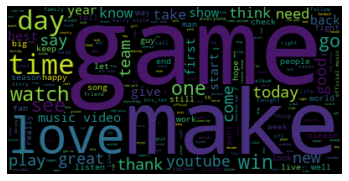

In [10]:
text_data1 = sm_tweets['lemmatized_text'].astype(str) # Extract the text column
text = ' '.join(text_data1) # Concatenate all the text data into a single string
wordcloud = WordCloud().generate(text) # Generate word cloud

# Create a plot and display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [11]:
# Initialize stemming
stemmer = PorterStemmer()
def stemmed_text(text):
    text = re.sub(regex_removal, '', text, flags=re.MULTILINE) # Apply regex
    text = text.lower() # Convert to lower case
    tokens = word_tokenize(text) # Tokenize the text
    tokens = [stemmer.stem(token) for token in tokens if token not in stop_words] # stem the tokens
    return " ".join(tokens)
sm_tweets['stemmed_text'] = sm_tweets['text'].apply(stemmed_text)
sm_tweets.head(5)

,text,date,label,id,label_name,lemmatized_text,stemmed_text
0,"The {@Clinton LumberKings@} beat the {@Cedar Rapids Kernels@} 4-0 in Game 1 of the Western Division finals. Evan Edwards hit a 2-run HR. WP Josh Roberson: 5 IP, 3 H, 0 R, 0 BB, 10 K #MWLplayoffs #MWLscoreboard",2019-09-08,4,1170516324419866624,sports_&_gaming,clinton lumberkings beat cedar rapid kernel game western division final evan edward hit run josh roberson,clinton lumberk beat cedar rapid kernel game western divis final evan edward hit run josh roberson
1,I would rather hear Eli Gold announce this Auburn game than these dumbasses. {@ESPN@},2019-09-08,4,1170516440690176006,sports_&_gaming,would rather hear eli gold announce auburn game dumbass espn,would rather hear eli gold announc auburn game dumbass espn
2,"Someone take my phone away, I’m trying to not look at {@Chicago Blackhawks@} home game tickets in October",2019-09-08,4,1170516543387709440,sports_&_gaming,someone take phone away try look chicago blackhawks home game ticket october,someon take phone away tri look chicago blackhawk home game ticket octob
3,"A year ago, Louisville struggled to beat an FCS opponent, ISU. Yes they won 31-7, but score wasn’t indicative of the game flow. Today, they are demoralizing a better FCS opponent in EKU. {@Coach Satterfield@} thank you!! {{USERNAME}} , glad you’re gone.",2019-09-08,4,1170516620466429953,sports_&_gaming,year ago louisville struggle beat fcs opponent isu yes score indicative game flow today demoralize well fcs opponent eku coach satterfield thank glad go,year ago louisvil struggl beat fc oppon isu ye score indic game flow today demor better fc oppon eku coach satterfield thank glad gone
4,Anyone know why the #Dodgers #Orioles game next Thursday 9/12 is on Fox?? That’s arguably the last game on the entire schedule I’d imagine being on Fox. {@Bill Shaikin@} {@Eric Stephen@} {@David Vassegh@},2019-09-08,4,1170516711411310592,sports_&_gaming,anyone know game next thursday fox arguably last game entire schedule imagine fox bill shaikin eric stephen david vassegh,anyon know game next thursday fox arguabl last game entir schedul imagin fox bill shaikin eric stephen david vassegh


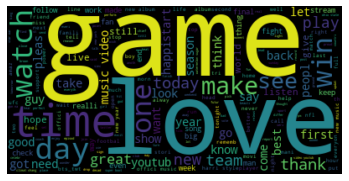

In [12]:
# Extract the text column
text_data2 = sm_tweets['stemmed_text'].astype(str)

# Concatenate all the text data into a single string
text = ' '.join(text_data2)

# Generate word cloud
wordcloud = WordCloud().generate(text)

# Create a plot and display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [13]:
#save cleaned dataset
# useful columns
selected_columns = ['text', 'label', 'label_name', 'lemmatized_text', 'stemmed_text']

# Write the selected columns to a CSV file
sm_tweets[selected_columns].to_csv('sm_tweets.csv', index=False)

In [14]:
#parse clean dataset
sm_tweets = pd.read_csv('sm_tweets.csv')
pd.set_option('display.max_colwidth', None)
sm_tweets.head(5)

,text,label,label_name,lemmatized_text,stemmed_text
0,"The {@Clinton LumberKings@} beat the {@Cedar Rapids Kernels@} 4-0 in Game 1 of the Western Division finals. Evan Edwards hit a 2-run HR. WP Josh Roberson: 5 IP, 3 H, 0 R, 0 BB, 10 K #MWLplayoffs #MWLscoreboard",4,sports_&_gaming,clinton lumberkings beat cedar rapid kernel game western division final evan edward hit run josh roberson,clinton lumberk beat cedar rapid kernel game western divis final evan edward hit run josh roberson
1,I would rather hear Eli Gold announce this Auburn game than these dumbasses. {@ESPN@},4,sports_&_gaming,would rather hear eli gold announce auburn game dumbass espn,would rather hear eli gold announc auburn game dumbass espn
2,"Someone take my phone away, I’m trying to not look at {@Chicago Blackhawks@} home game tickets in October",4,sports_&_gaming,someone take phone away try look chicago blackhawks home game ticket october,someon take phone away tri look chicago blackhawk home game ticket octob
3,"A year ago, Louisville struggled to beat an FCS opponent, ISU. Yes they won 31-7, but score wasn’t indicative of the game flow. Today, they are demoralizing a better FCS opponent in EKU. {@Coach Satterfield@} thank you!! {{USERNAME}} , glad you’re gone.",4,sports_&_gaming,year ago louisville struggle beat fcs opponent isu yes score indicative game flow today demoralize well fcs opponent eku coach satterfield thank glad go,year ago louisvil struggl beat fc oppon isu ye score indic game flow today demor better fc oppon eku coach satterfield thank glad gone
4,Anyone know why the #Dodgers #Orioles game next Thursday 9/12 is on Fox?? That’s arguably the last game on the entire schedule I’d imagine being on Fox. {@Bill Shaikin@} {@Eric Stephen@} {@David Vassegh@},4,sports_&_gaming,anyone know game next thursday fox arguably last game entire schedule imagine fox bill shaikin eric stephen david vassegh,anyon know game next thursday fox arguabl last game entir schedul imagin fox bill shaikin eric stephen david vassegh


In [15]:
# Upsample the dataset based on the "label_name" column
balanced_data = pd.DataFrame()

# Get the class with the maximum count
max_count = sm_tweets['label_name'].value_counts().max()

# Iterate over each unique label in the dataset
for label in sm_tweets['label_name'].unique():
    # Get the subset of data for the current label
    subset = sm_tweets[sm_tweets['label_name'] == label]
    
    # Upsample the minority class to match the count of the majority class
    subset_upsampled = resample(subset, n_samples=max_count, replace=True, random_state=42)
    
    # Concatenate the upsampled subset with the balanced dataset
    balanced_data = pd.concat([balanced_data, subset_upsampled])

# Shuffle the balanced dataset
up_balanced_data = balanced_data.sample(frac=1, random_state=42)

up_balanced_data.head()


,text,label,label_name,lemmatized_text,stemmed_text
2358,"I don t understand why some people are totally against doing a streaming party with a rapper s fandom Nowadays rappers have many songs with different genre rock, rnb, pop, dancehall, house, edm, reggaeton... There are many who can blend in GOT7 s songs #GOT7 {@GOT7@}",2,pop_culture,understand people totally stream party rapper fandom nowadays rapper many song different genre rock rnb pop dancehall house edm reggaeton many blend get song get,understand peopl total stream parti rapper fandom nowaday rapper mani song differ genr rock rnb pop dancehal hous edm reggaeton mani blend got song got
1172,Many fab authors donating signed books and illos to support #cfa through Twitter auctions looking forward to a few bids tomorrow! #AuthorsForFireys Great initiative by {{USERNAME}},0,arts_&_culture,many fab author donate sign book illos support twitter auction look forward bid tomorrow great initiative,mani fab author donat sign book illo support twitter auction look forward bid tomorrow great initi
3059,The Fight or Fright skin recolors for the {@Apex Legends@} legends look really cool and lowkey want to get them alllllll,4,sports_&_gaming,fight fright skin recolors apex legends legend look really cool lowkey want get alllllll,fight fright skin recolor apex legend legend look realli cool lowkey want get alllllll
3399,The owner of {{USERNAME}} has announced that its sales in the second half of 2020 exceeded expectations by millions {{URL}} #cosmetics #sales,1,business_&_entrepreneurs,owner announce sale second half exceed expectation million,owner announc sale second half exceed expect million
3612,Listen {@Drizzy@} bodied Lemon Pepper freestyle !!! FACTS,2,pop_culture,listen drizzy body lemon pepper freestyle fact,listen drizzi bodi lemon pepper freestyl fact


In [16]:
# Count the rows based on the label_id column
row_counts = up_balanced_data['label_name'].value_counts()
# Print the count of each label_id
print(row_counts)

pop_culture                 2512
arts_&_culture              2512
sports_&_gaming             2512
business_&_entrepreneurs    2512
science_&_technology        2512
daily_life                  2512
Name: label_name, dtype: int64


In [17]:
# Downsample the dataset based on the "label_name" column
balanced_data = pd.DataFrame()

# Get the class with the minimum count
min_count = sm_tweets['label_name'].value_counts().min()

# Iterate over each unique label in the dataset
for label in sm_tweets['label_name'].unique():
    # Get the subset of data for the current label
    subset = sm_tweets[sm_tweets['label_name'] == label]
    
    # Downsample the majority class to match the count of the minority class
    subset_downsampled = resample(subset, n_samples=min_count, replace=False, random_state=42)
    
    # Concatenate the downsampled subset with the balanced dataset
    balanced_data = pd.concat([balanced_data, subset_downsampled])

# Shuffle the balanced dataset
down_balanced_data = balanced_data.sample(frac=1, random_state=42)

down_balanced_data.head()


,text,label,label_name,lemmatized_text,stemmed_text
869,Spotify wrapped 1) {@Stray Kids@} 2) {@BTS_twt@} 3) Blackpink 4) {@MONTERO@} 5) {@Red Velvet@} I love how it’s all kpop then you got Lil Nas X just there lmaooo,2,pop_culture,spotify wrap stray kid bts_twt blackpink montero red velvet love kpop get lil nas lmaooo,spotifi wrap stray kid bts_twt blackpink montero red velvet love kpop got lil na lmaooo
5333,"I don’t have any real New Years resolutions but if I did it would be to read and workout more often. Luckily, {@Barack Obama@} ’s new book is giving me a bit of both (get it....cuz it’s a book that’s also heavy af?). Seriously tho, I could read it for hours if I were in better shape.",0,arts_&_culture,real new year resolution would read workout often luckily barack obama new book give bit get cuz book also heavy seriously tho could read hour good shape,real new year resolut would read workout often luckili barack obama new book give bit get cuz book also heavi serious tho could read hour better shape
849,"The Hutchinson Overide may be better suited to tamer paths and pavement, per {{USERNAME}} See why on {{USERNAME}} At The Finish review here: {{URL}} #tarvelbygravel #graveltravel",5,science_&_technology,hutchinson overide may well suit tame path pavement per see finish review,hutchinson overid may better suit tamer path pavement per see finish review
2128,"Shoutout to my sister friend lover girl {{USERNAME}} she’s definitely a day one stay by your side, genuine person, genuine Taurus and like the greatest thing ever! ❤️ it’s Mother’s Day &she was there when I had my first child! I wish you many blessings and great thing this year!",3,daily_life,shoutout sister friend lover girl definitely day one stay side genuine person genuine taurus like great thing ever mother day first child wish many blessing great thing year,shoutout sister friend lover girl definit day one stay side genuin person genuin tauru like greatest thing ever mother day first child wish mani bless great thing year
1159,Looking forward to the match up between {@Clemson Football@} & {@LSU Football@} for the CFP National Championship. Aussie Fans this one is Tuesday @ 12PM on {@ESPN@} {@ESPN College Football@},4,sports_&_gaming,look forward match clemson football lsu football cfp national championship aussie fan one tuesday pm espn espn college football,look forward match clemson footbal lsu footbal cfp nation championship aussi fan one tuesday pm espn espn colleg footbal


In [18]:
# Count the rows based on the label_id column
row_counts = down_balanced_data['label_name'].value_counts()
# Print the count of each label_id
print(row_counts)

pop_culture                 144
arts_&_culture              144
science_&_technology        144
daily_life                  144
sports_&_gaming             144
business_&_entrepreneurs    144
Name: label_name, dtype: int64


## Data Splitting

In [19]:
# Split oversampled dataset into train and test sets
up_train_sm_tweets, up_test_sm_tweets = train_test_split(up_balanced_data, test_size=0.2, random_state=42)

# Split undersampled dataset into train and test sets
down_train_sm_tweets, down_test_sm_tweets = train_test_split(down_balanced_data, test_size=0.2, random_state=42)

# Split undersampled dataset into train and test sets
train_sm_tweets, test_sm_tweets = train_test_split(sm_tweets, test_size=0.2, random_state=42)

## Feature Engineering 

Creation of an NLP Pipeline using B-o-W and TF-IDF text representation techniques 

Adoption of Naive Bayes, Logistic Regression and Support Vector Machine Classifiers

In [20]:
def BOW_pipeline(classifier):
    # Define the pipeline steps
    steps = [
        ('vectorizer', CountVectorizer(),
        ('classifier', classifier)
    ]
    
    # Create the NLP pipeline
    BOW_nlp_pipeline = Pipeline(steps)
    
    return BOW_nlp_pipeline
# Instantiate the classifiers
NB_BOW = MultinomialNB()
LR_BOW = LogisticRegression()
SVM_BOW = SVC()
# Create the NLP pipelines for Naive Bayes, SVM and Logistic Regression using BOW text representation
BOW_NB_pipeline = BOW_pipeline(NB_BOW)
BOW_LR_pipeline = BOW_pipeline(LR_BOW)
BOW_SVM_pipeline = BOW_pipeline(SVM_BOW)


def TFIDF_pipeline(classifier):
    # Define the pipeline steps
    steps = [
        ('vectorizer', TfidfVectorizer()),
        ('classifier', classifier)
    ]
    # Create the NLP pipeline
    TFIDF_nlp_pipeline = Pipeline(steps)
    
    return TFIDF_nlp_pipeline
# Instantiate the classifiers
NB_TFIDF = MultinomialNB()
LR_TFIDF = LogisticRegression()
SVM_TFIDF = SVC()
# Create the NLP pipelines for Naive Bayes, SVM and Logistic Regression using TFIDF text representation
TFIDF_NB_pipeline = BOW_pipeline(NB_BOW)
TFIDF_LR_pipeline = BOW_pipeline(LR_BOW)
TFIDF_SVM_pipeline = BOW_pipeline(SVM_BOW)

# Model Evaluation

### Lemmatized approach using BOW text representation

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.04      0.08        25
           1       0.89      0.28      0.43        60
           2       0.78      0.88      0.83       497
           3       0.63      0.51      0.56       179
           4       0.82      0.95      0.88       468
           5       0.77      0.33      0.47        60

    accuracy                           0.78      1289
   macro avg       0.82      0.50      0.54      1289
weighted avg       0.78      0.78      0.76      1289

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.12      0.21        25
           1       0.89      0.42      0.57        60
           2       0.82      0.85      0.84       497
           3       0.60      0.66      0.63       179
           4       0.85      0.91      0.88       468
           5       0.64      0.48      0.55        60


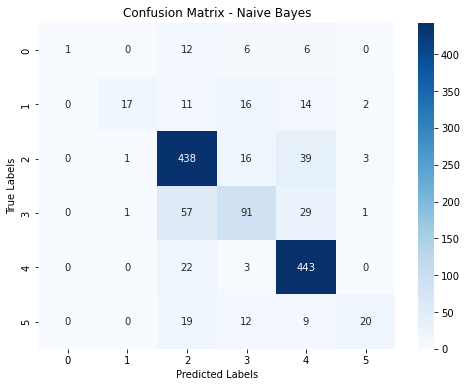

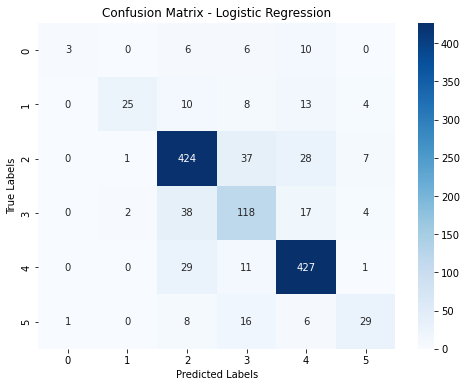

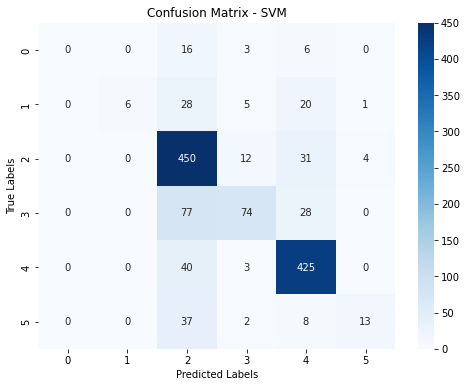

In [21]:
#Naive Bayes
BOW_NB_pipeline.fit(train_sm_tweets['lemmatized_text'], train_sm_tweets['label'])#Fit the NB pipeline to training data
LEM_pred_NB = BOW_NB_pipeline.predict(test_sm_tweets['lemmatized_text'])#Predict on the test data using Naive Bayes
LEM_accuracy_NB = accuracy_score(test_sm_tweets['label'], LEM_pred_NB)

#Logistic Regression
BOW_LR_pipeline.fit(train_sm_tweets['lemmatized_text'], train_sm_tweets['label'])#Fit the LR pipeline on the training data
LEM_pred_LR = BOW_LR_pipeline.predict(test_sm_tweets['lemmatized_text']) # Predict on the test data using LR
LEM_accuracy_LR = accuracy_score(test_sm_tweets['label'], LEM_pred_LR)

#SVM
BOW_SVM_pipeline.fit(train_sm_tweets['lemmatized_text'], train_sm_tweets['label'])#Fit the SVM pipeline on the training data
LEM_pred_SVM = BOW_SVM_pipeline.predict(test_sm_tweets['lemmatized_text'])#Predict on the test data using SVM
LEM_accuracy_SVM = accuracy_score(test_sm_tweets['label'], LEM_pred_SVM)

# Calculate precision, recall, and F1 score for Naive Bayes
report_NB = classification_report(test_sm_tweets['label'], LEM_pred_NB, zero_division=0)
print("Naive Bayes Classification Report:")
print(report_NB)

# Calculate precision, recall, and F1 score for LR
report_LR = classification_report(test_sm_tweets['label'], LEM_pred_LR, zero_division=0)
print("Logistic Regression Classification Report:")
print(report_LR)

# Calculate precision, recall, and F1 score for SVM
report_SVM = classification_report(test_sm_tweets['label'], LEM_pred_SVM, zero_division=0)
print("SVM Classification Report:")
print(report_SVM)


#confusion matrix
# Naive Bayes
confusion_NB = confusion_matrix(test_sm_tweets['label'], LEM_pred_NB)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_NB, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix_NB.png')
plt.show()

# Logistic Regression
confusion_LR = confusion_matrix(test_sm_tweets['label'], LEM_pred_LR)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_LR, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix_LR.png')
plt.show()

# SVM
confusion_SVM = confusion_matrix(test_sm_tweets['label'], LEM_pred_SVM)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_SVM, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix_SVM.png')
plt.show()


### Stemmed Approach using BOW text representation

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.04      0.08        25
           1       0.89      0.28      0.43        60
           2       0.81      0.88      0.84       497
           3       0.62      0.54      0.57       179
           4       0.82      0.95      0.88       468
           5       0.74      0.38      0.51        60

    accuracy                           0.79      1289
   macro avg       0.81      0.51      0.55      1289
weighted avg       0.79      0.79      0.77      1289

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.12      0.21        25
           1       0.89      0.42      0.57        60
           2       0.82      0.86      0.84       497
           3       0.63      0.68      0.65       179
           4       0.86      0.91      0.88       468
           5       0.65      0.52      0.57        60


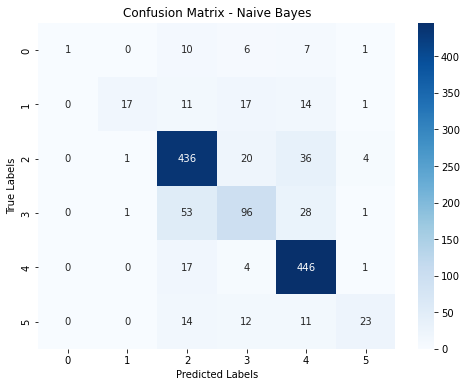

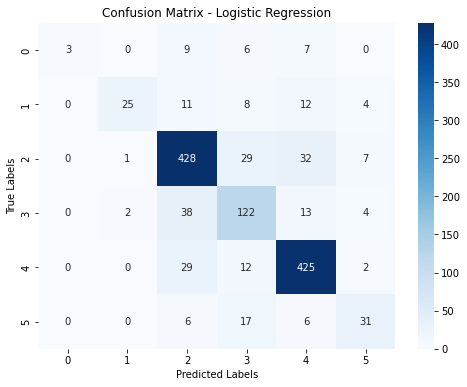

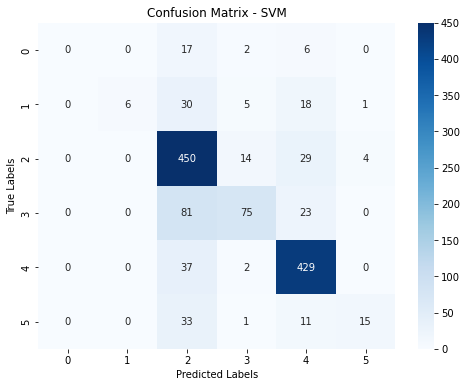

In [22]:
#Naive Bayes
BOW_NB_pipeline.fit(train_sm_tweets['stemmed_text'], train_sm_tweets['label'])#Fit the NB pipeline to training data
STEM_BOW_pred_NB = BOW_NB_pipeline.predict(test_sm_tweets['stemmed_text'])#Predict on the test data using Naive Bayes
STEM_BOW_accuracy_NB = accuracy_score(test_sm_tweets['label'], STEM_BOW_pred_NB)

#Logistic Regression
BOW_LR_pipeline.fit(train_sm_tweets['stemmed_text'], train_sm_tweets['label'])#Fit the LR pipeline on the training data
STEM_BOW_pred_LR = BOW_LR_pipeline.predict(test_sm_tweets['stemmed_text']) # Predict on the test data using LR
STEM_BOW_accuracy_LR = accuracy_score(test_sm_tweets['label'], STEM_BOW_pred_LR)

#SVM
BOW_SVM_pipeline.fit(train_sm_tweets['stemmed_text'], train_sm_tweets['label'])#Fit the SVM pipeline on the training data
STEM_BOW_pred_SVM = BOW_SVM_pipeline.predict(test_sm_tweets['stemmed_text'])#Predict on the test data using SVM
STEM_BOW_accuracy_SVM = accuracy_score(test_sm_tweets['label'], STEM_BOW_pred_SVM)


# Calculate precision, recall, and F1 score for Naive Bayes
report_NB = classification_report(test_sm_tweets['label'], STEM_BOW_pred_NB, zero_division=0)
print("Naive Bayes Classification Report:")
print(report_NB)

# Calculate precision, recall, and F1 score for LR
report_LR = classification_report(test_sm_tweets['label'], STEM_BOW_pred_LR, zero_division=0)
print("Logistic Regression Classification Report:")
print(report_LR)

# Calculate precision, recall, and F1 score for SVM
report_SVM = classification_report(test_sm_tweets['label'], STEM_BOW_pred_SVM, zero_division=0)
print("SVM Classification Report:")
print(report_SVM)

#confusion matrix

# Naive Bayes
confusion_NB = confusion_matrix(test_sm_tweets['label'], STEM_BOW_pred_NB)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_NB, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix_NB.png')
plt.show()

# Logistic Regression
confusion_LR = confusion_matrix(test_sm_tweets['label'], STEM_BOW_pred_LR)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_LR, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix_LR.png')
plt.show()

# SVM
confusion_SVM = confusion_matrix(test_sm_tweets['label'], STEM_BOW_pred_SVM)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_SVM, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix_SVM.png')
plt.show()


### Lemmatized using TFIDF text representation approach

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.04      0.08        25
           1       0.89      0.28      0.43        60
           2       0.78      0.88      0.83       497
           3       0.63      0.51      0.56       179
           4       0.82      0.95      0.88       468
           5       0.77      0.33      0.47        60

    accuracy                           0.78      1289
   macro avg       0.82      0.50      0.54      1289
weighted avg       0.78      0.78      0.76      1289

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.12      0.21        25
           1       0.89      0.42      0.57        60
           2       0.82      0.85      0.84       497
           3       0.60      0.66      0.63       179
           4       0.85      0.91      0.88       468
           5       0.64      0.48      0.55        60


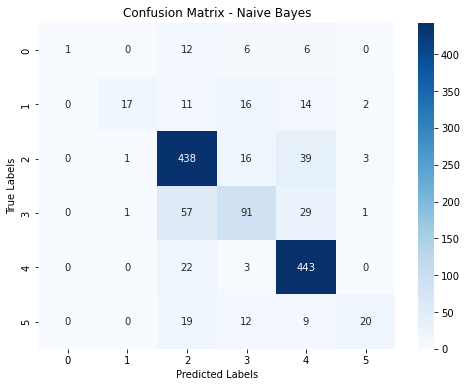

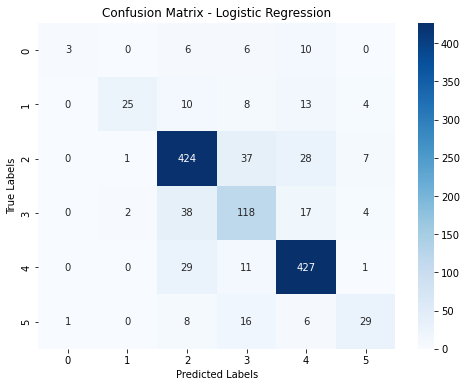

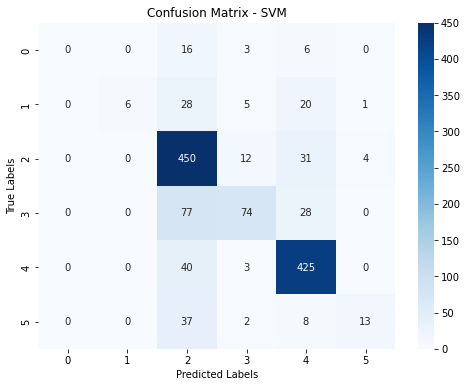

In [23]:
#Naive Bayes
TFIDF_NB_pipeline.fit(train_sm_tweets['lemmatized_text'], train_sm_tweets['label'])#Fit the NB pipeline to training data
LEM_TF_pred_NB = TFIDF_NB_pipeline.predict(test_sm_tweets['lemmatized_text'])#Predict on the test data using Naive Bayes
LEM_TF_accuracy_NB = accuracy_score(test_sm_tweets['label'], LEM_TF_pred_NB)

#Logistic Regression
TFIDF_LR_pipeline.fit(train_sm_tweets['lemmatized_text'], train_sm_tweets['label'])#Fit the LR pipeline on the training data
LEM_TF_pred_LR = TFIDF_LR_pipeline.predict(test_sm_tweets['lemmatized_text']) # Predict on the test data using LR
LEM_TF_accuracy_LR = accuracy_score(test_sm_tweets['label'], LEM_TF_pred_LR)

#SVM
TFIDF_SVM_pipeline.fit(train_sm_tweets['lemmatized_text'], train_sm_tweets['label'])#Fit the SVM pipeline on the training data
LEM_TF_pred_SVM = TFIDF_SVM_pipeline.predict(test_sm_tweets['lemmatized_text'])#Predict on the test data using SVM
LEM_TF_accuracy_SVM = accuracy_score(test_sm_tweets['label'], LEM_TF_pred_SVM)

# Calculate precision, recall, and F1 score for Naive Bayes
report_NB = classification_report(test_sm_tweets['label'], LEM_TF_pred_NB, zero_division=0)
print("Naive Bayes Classification Report:")
print(report_NB)

# Calculate precision, recall, and F1 score for LR
report_LR = classification_report(test_sm_tweets['label'], LEM_TF_pred_LR, zero_division=0)
print("Logistic Regression Classification Report:")
print(report_LR)

# Calculate precision, recall, and F1 score for SVM
report_SVM = classification_report(test_sm_tweets['label'], LEM_TF_pred_SVM, zero_division=0)
print("SVM Classification Report:")
print(report_SVM)

#confusion matrix

# Naive Bayes
confusion_NB = confusion_matrix(test_sm_tweets['label'], LEM_TF_pred_NB)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_NB, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix_NB.png')
plt.show()

# Logistic Regression
confusion_LR = confusion_matrix(test_sm_tweets['label'], LEM_TF_pred_LR)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_LR, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix_LR.png')
plt.show()

# SVM
confusion_SVM = confusion_matrix(test_sm_tweets['label'], LEM_TF_pred_SVM)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_SVM, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix_SVM.png')
plt.show()

### Stemmed approach using TFIDF text representation approach

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.04      0.08        25
           1       0.89      0.28      0.43        60
           2       0.81      0.88      0.84       497
           3       0.62      0.54      0.57       179
           4       0.82      0.95      0.88       468
           5       0.74      0.38      0.51        60

    accuracy                           0.79      1289
   macro avg       0.81      0.51      0.55      1289
weighted avg       0.79      0.79      0.77      1289

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.12      0.21        25
           1       0.89      0.42      0.57        60
           2       0.82      0.86      0.84       497
           3       0.63      0.68      0.65       179
           4       0.86      0.91      0.88       468
           5       0.65      0.52      0.57        60


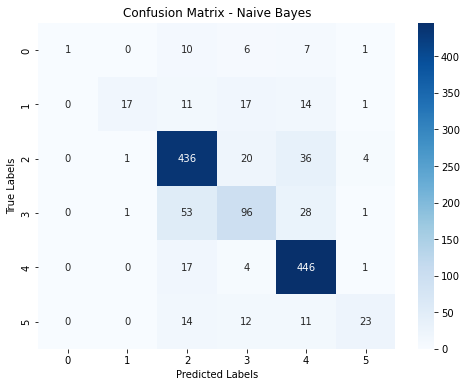

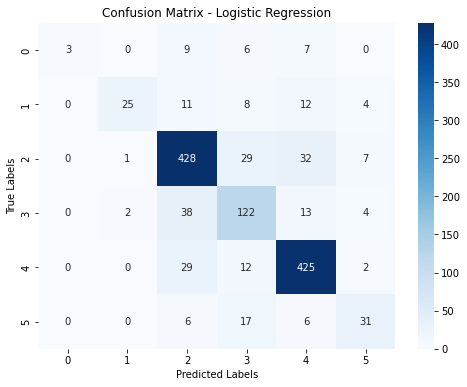

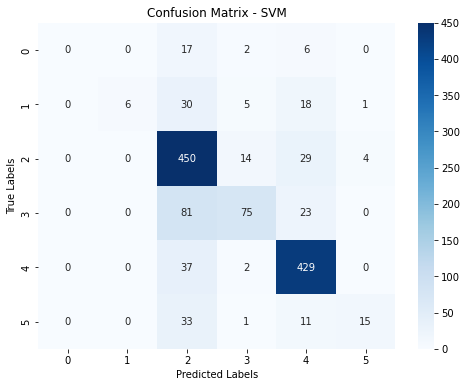

In [24]:
#Naive Bayes
TFIDF_NB_pipeline.fit(train_sm_tweets['stemmed_text'], train_sm_tweets['label'])#Fit the NB pipeline to training data
STEM_TF_pred_NB = TFIDF_NB_pipeline.predict(test_sm_tweets['stemmed_text'])#Predict on the test data using Naive Bayes
STEM_TF_accuracy_NB = accuracy_score(test_sm_tweets['label'], STEM_TF_pred_NB)

#Logistic Regression
TFIDF_LR_pipeline.fit(train_sm_tweets['stemmed_text'], train_sm_tweets['label'])#Fit the LR pipeline on the training data
STEM_TF_pred_LR = TFIDF_LR_pipeline.predict(test_sm_tweets['stemmed_text']) # Predict on the test data using LR
STEM_TF_accuracy_LR = accuracy_score(test_sm_tweets['label'], STEM_TF_pred_LR)

#SVM
TFIDF_SVM_pipeline.fit(train_sm_tweets['stemmed_text'], train_sm_tweets['label'])#Fit the SVM pipeline on the training data
STEM_TF_pred_SVM = TFIDF_SVM_pipeline.predict(test_sm_tweets['stemmed_text'])#Predict on the test data using SVM
STEM_TF_accuracy_SVM = accuracy_score(test_sm_tweets['label'], STEM_TF_pred_SVM)


# Calculate precision, recall, and F1 score for Naive Bayes
report_NB = classification_report(test_sm_tweets['label'], STEM_TF_pred_NB, zero_division=0)
print("Naive Bayes Classification Report:")
print(report_NB)

# Calculate precision, recall, and F1 score for LR
report_LR = classification_report(test_sm_tweets['label'], STEM_TF_pred_LR, zero_division=0)
print("Logistic Regression Classification Report:")
print(report_LR)

# Calculate precision, recall, and F1 score for SVM
report_SVM = classification_report(test_sm_tweets['label'], STEM_TF_pred_SVM, zero_division=0)
print("SVM Classification Report:")
print(report_SVM)

#confusion matrix

# Naive Bayes
confusion_NB = confusion_matrix(test_sm_tweets['label'], STEM_TF_pred_NB)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_NB, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix_NB.png')
plt.show()

# Logistic Regression
confusion_LR = confusion_matrix(test_sm_tweets['label'], STEM_TF_pred_LR)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_LR, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix_LR.png')
plt.show()

# SVM
confusion_SVM = confusion_matrix(test_sm_tweets['label'], STEM_TF_pred_SVM)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_SVM, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix_SVM.png')
plt.show()

### Stemmed approach using BOW text representation approach on Oversampled Dataset

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       503
           1       0.96      0.95      0.95       505
           2       0.96      0.86      0.91       504
           3       0.87      0.91      0.89       470
           4       0.95      0.93      0.94       511
           5       0.95      0.98      0.97       522

    accuracy                           0.94      3015
   macro avg       0.94      0.94      0.94      3015
weighted avg       0.94      0.94      0.94      3015

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       503
           1       0.98      1.00      0.99       505
           2       0.94      0.90      0.92       504
           3       0.93      0.95      0.94       470
           4       0.96      0.94      0.95       511
           5       0.98      1.00      0.99       522


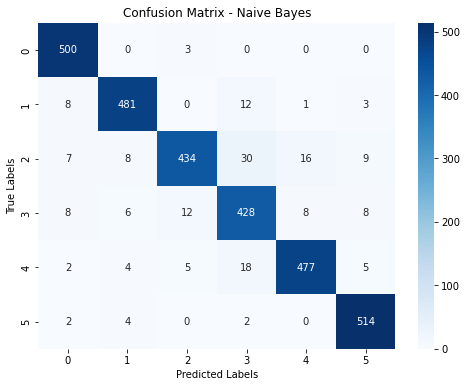

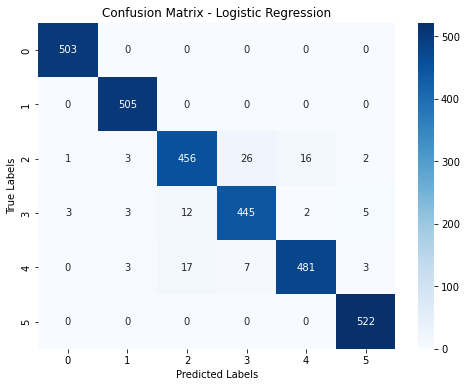

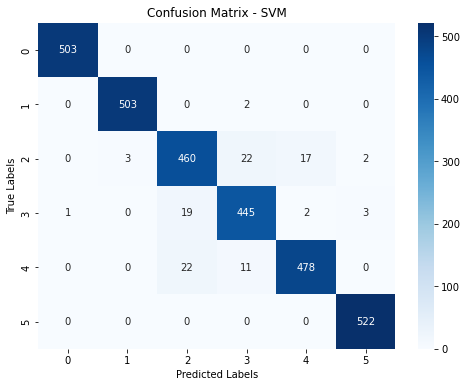

In [25]:
#Naive Bayes
BOW_NB_pipeline.fit(up_train_sm_tweets['stemmed_text'], up_train_sm_tweets['label'])#Fit the NB pipeline to training data
UP_BOW_pred_NB = BOW_NB_pipeline.predict(up_test_sm_tweets['stemmed_text'])#Predict on the test data using Naive Bayes
UP_BOW_accuracy_NB = accuracy_score(up_test_sm_tweets['label'], UP_BOW_pred_NB)

#Logistic Regression
BOW_LR_pipeline.fit(up_train_sm_tweets['stemmed_text'], up_train_sm_tweets['label'])#Fit the LR pipeline on the training data
UP_BOW_pred_LR = BOW_LR_pipeline.predict(up_test_sm_tweets['stemmed_text']) # Predict on the test data using LR
UP_BOW_accuracy_LR = accuracy_score(up_test_sm_tweets['label'], UP_BOW_pred_LR)

#SVM
BOW_SVM_pipeline.fit(up_train_sm_tweets['stemmed_text'], up_train_sm_tweets['label'])#Fit the SVM pipeline on the training data
UP_BOW_pred_SVM = BOW_SVM_pipeline.predict(up_test_sm_tweets['stemmed_text'])#Predict on the test data using SVM
UP_BOW_accuracy_SVM = accuracy_score(up_test_sm_tweets['label'], UP_BOW_pred_SVM)


# Calculate precision, recall, and F1 score for Naive Bayes
report_NB = classification_report(up_test_sm_tweets['label'], UP_BOW_pred_NB, zero_division=0)
print("Naive Bayes Classification Report:")
print(report_NB)

# Calculate precision, recall, and F1 score for LR
report_LR = classification_report(up_test_sm_tweets['label'], UP_BOW_pred_LR, zero_division=0)
print("Logistic Regression Classification Report:")
print(report_LR)

# Calculate precision, recall, and F1 score for SVM
report_SVM = classification_report(up_test_sm_tweets['label'], UP_BOW_pred_SVM, zero_division=0)
print("SVM Classification Report:")
print(report_SVM)


#confusion matrix

# Naive Bayes
confusion_NB = confusion_matrix(up_test_sm_tweets['label'], UP_BOW_pred_NB)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_NB, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix_NB.png')
plt.show()

# Logistic Regression
confusion_LR = confusion_matrix(up_test_sm_tweets['label'], UP_BOW_pred_LR)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_LR, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix_LR.png')
plt.show()

# SVM
confusion_SVM = confusion_matrix(up_test_sm_tweets['label'], UP_BOW_pred_SVM)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_SVM, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix_SVM.png')
plt.show()

### Stemmed approach using TFIDF text representation approach on Oversampled Dataset

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       503
           1       0.96      0.95      0.95       505
           2       0.96      0.86      0.91       504
           3       0.87      0.91      0.89       470
           4       0.95      0.93      0.94       511
           5       0.95      0.98      0.97       522

    accuracy                           0.94      3015
   macro avg       0.94      0.94      0.94      3015
weighted avg       0.94      0.94      0.94      3015

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       503
           1       0.98      1.00      0.99       505
           2       0.94      0.90      0.92       504
           3       0.93      0.95      0.94       470
           4       0.96      0.94      0.95       511
           5       0.98      1.00      0.99       522


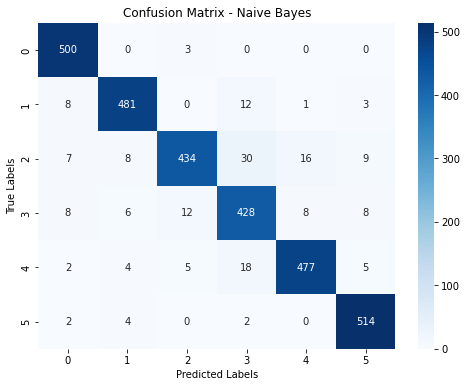

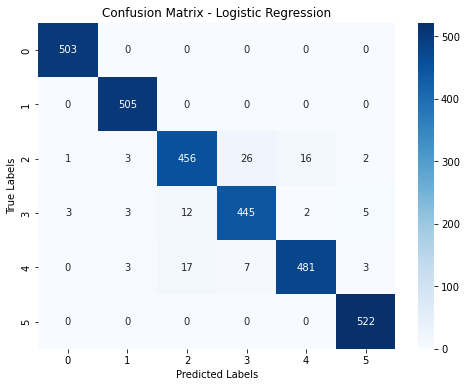

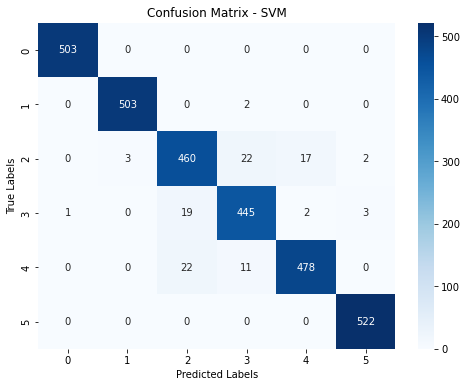

In [26]:
#Naive Bayes
TFIDF_NB_pipeline.fit(up_train_sm_tweets['stemmed_text'], up_train_sm_tweets['label'])#Fit the NB pipeline to training data
UP_STEM_TF_pred_NB = TFIDF_NB_pipeline.predict(up_test_sm_tweets['stemmed_text'])#Predict on the test data using Naive Bayes
UP_STEM_TF_accuracy_NB = accuracy_score(up_test_sm_tweets['label'], UP_STEM_TF_pred_NB)

#Logistic Regression
TFIDF_LR_pipeline.fit(up_train_sm_tweets['stemmed_text'], up_train_sm_tweets['label'])#Fit the LR pipeline on the training data
UP_STEM_TF_pred_LR = TFIDF_LR_pipeline.predict(up_test_sm_tweets['stemmed_text']) # Predict on the test data using LR
UP_STEM_TF_accuracy_LR = accuracy_score(up_test_sm_tweets['label'], UP_STEM_TF_pred_LR)

#SVM
TFIDF_SVM_pipeline.fit(up_train_sm_tweets['stemmed_text'], up_train_sm_tweets['label'])#Fit the SVM pipeline on the training data
UP_STEM_TF_pred_SVM = TFIDF_SVM_pipeline.predict(up_test_sm_tweets['stemmed_text'])#Predict on the test data using SVM
UP_STEM_TF_accuracy_SVM = accuracy_score(up_test_sm_tweets['label'], UP_STEM_TF_pred_SVM)


# Calculate precision, recall, and F1 score for Naive Bayes
report_NB = classification_report(up_test_sm_tweets['label'], UP_STEM_TF_pred_NB, zero_division=0)
print("Naive Bayes Classification Report:")
print(report_NB)

# Calculate precision, recall, and F1 score for LR
report_LR = classification_report(up_test_sm_tweets['label'], UP_STEM_TF_pred_LR, zero_division=0)
print("Logistic Regression Classification Report:")
print(report_LR)

# Calculate precision, recall, and F1 score for SVM
report_SVM = classification_report(up_test_sm_tweets['label'], UP_STEM_TF_pred_SVM, zero_division=0)
print("SVM Classification Report:")
print(report_SVM)

#confusion matrix

# Naive Bayes
confusion_NB = confusion_matrix(up_test_sm_tweets['label'], UP_STEM_TF_pred_NB)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_NB, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix_NB.png')
plt.show()

# Logistic Regression
confusion_LR = confusion_matrix(up_test_sm_tweets['label'], UP_STEM_TF_pred_LR)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_LR, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix_LR.png')
plt.show()

# SVM
confusion_SVM = confusion_matrix(up_test_sm_tweets['label'], UP_STEM_TF_pred_SVM)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_SVM, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix_SVM.png')
plt.show()

                                                      End